In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
pjme = pd.read_csv('../input/PJME_hourly.csv', index_col=[0], parse_dates=[0])
print(pjme)

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0

[145366 rows x 1 columns]


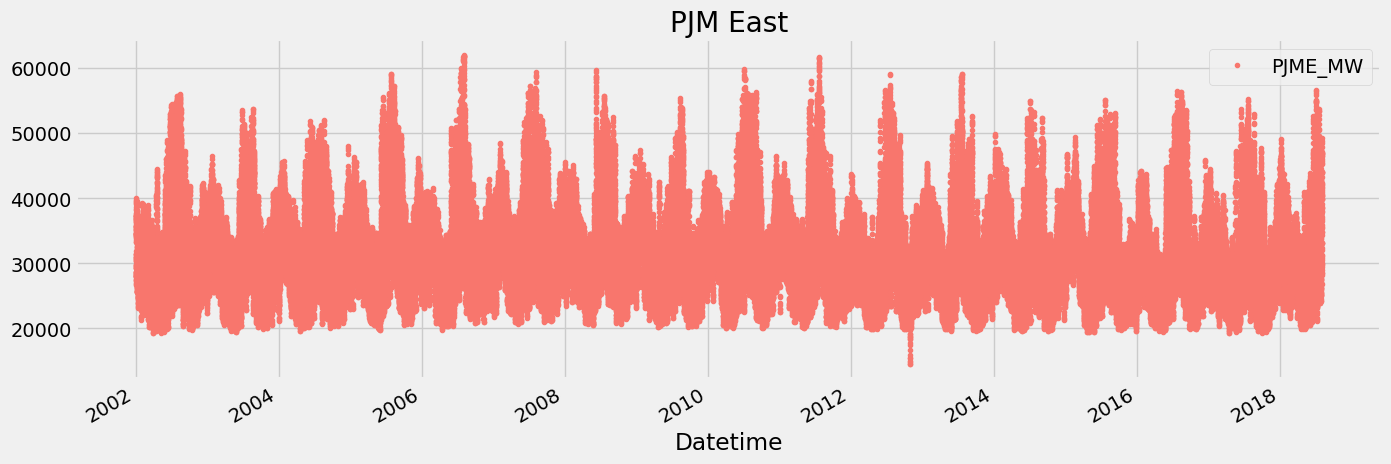

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [4]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()
print("PJME_TRAIN")
print(pjme_train)
print("PJME_TEST")
print(pjme_test)

PJME_TRAIN
                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2014-01-01 20:00:00  36193.0
2014-01-01 21:00:00  35601.0
2014-01-01 22:00:00  34242.0
2014-01-01 23:00:00  32215.0
2014-01-02 00:00:00  30159.0

[113927 rows x 1 columns]
PJME_TEST
                     PJME_MW
Datetime                    
2015-12-31 01:00:00  24305.0
2015-12-31 02:00:00  23156.0
2015-12-31 03:00:00  22514.0
2015-12-31 04:00:00  22330.0
2015-12-31 05:00:00  22773.0
...                      ...
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0

[31439 rows x 1 columns]


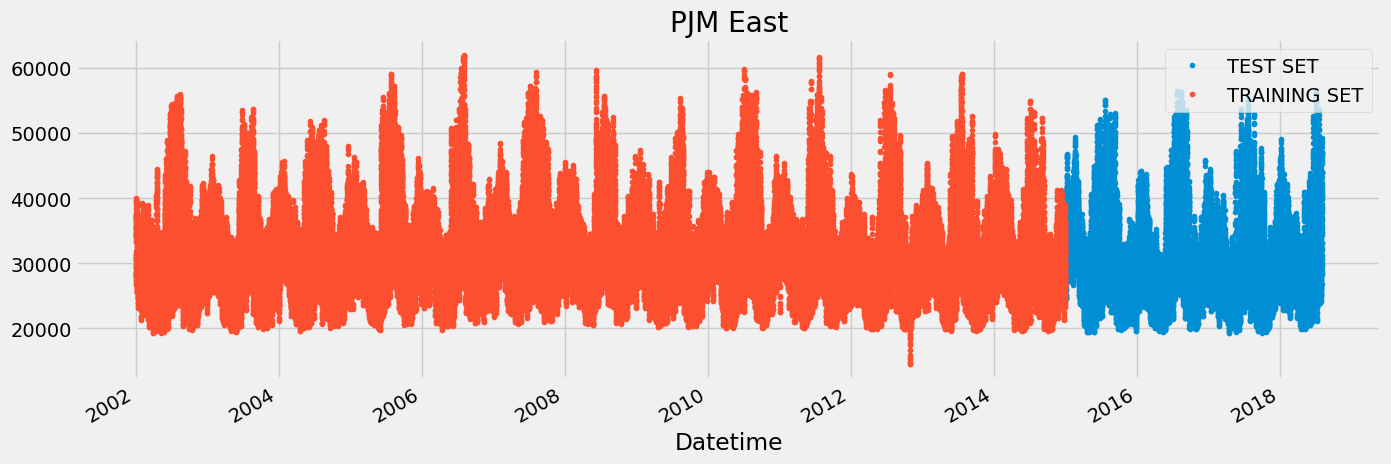

In [5]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    # df['weekofyear'] = df['date'].dt.weekofyear is DEPRECATED
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')
print(X_train)
print(y_train)
print(X_test)
print(y_test)

                     hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2002-12-31 01:00:00     1          1        4     12  2002        365   
2002-12-31 02:00:00     2          1        4     12  2002        365   
2002-12-31 03:00:00     3          1        4     12  2002        365   
2002-12-31 04:00:00     4          1        4     12  2002        365   
2002-12-31 05:00:00     5          1        4     12  2002        365   
...                   ...        ...      ...    ...   ...        ...   
2014-01-01 20:00:00    20          2        1      1  2014          1   
2014-01-01 21:00:00    21          2        1      1  2014          1   
2014-01-01 22:00:00    22          2        1      1  2014          1   
2014-01-01 23:00:00    23          2        1      1  2014          1   
2014-01-02 00:00:00     0          3        1      1  2014          2   

                     dayofmonth  weekofyear  
Date

In [8]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',  # thay reg:linear
    base_score=0.5,
    booster='gbtree',
    n_jobs=1,
    random_state=0,
    early_stopping_rounds=50,
    scale_pos_weight=1,
    verbosity=0                   # thay silent=True
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)


,objective,'reg:squarederror'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


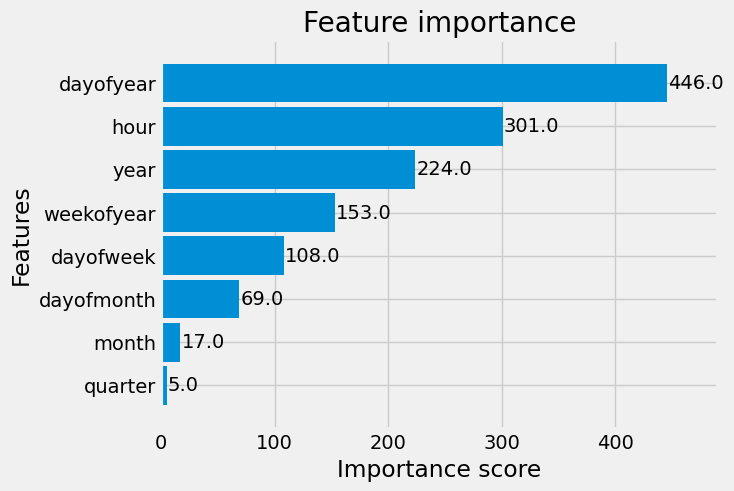

In [9]:
_ = plot_importance(reg, height=0.9)

In [10]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

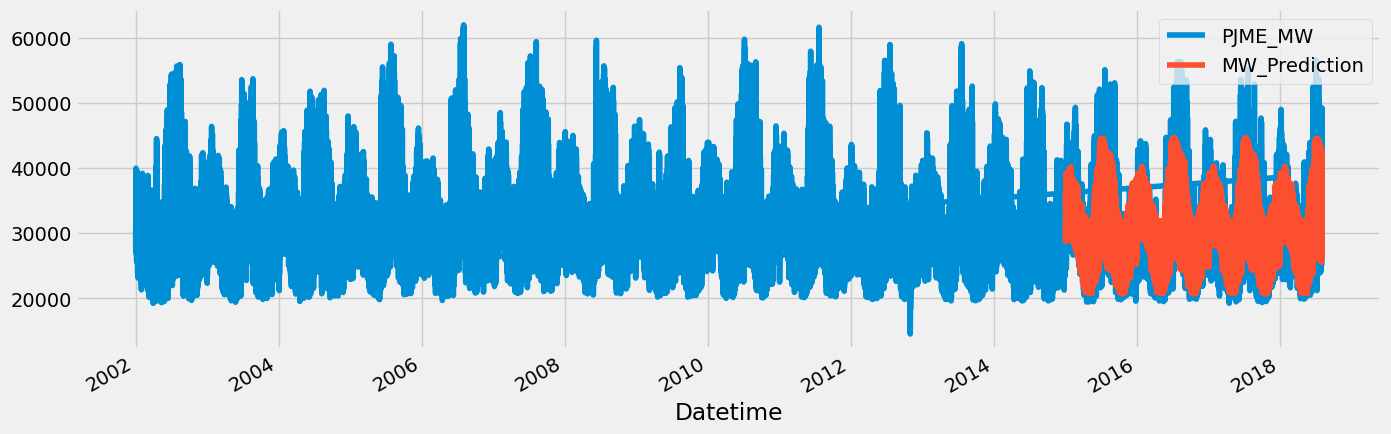

In [11]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

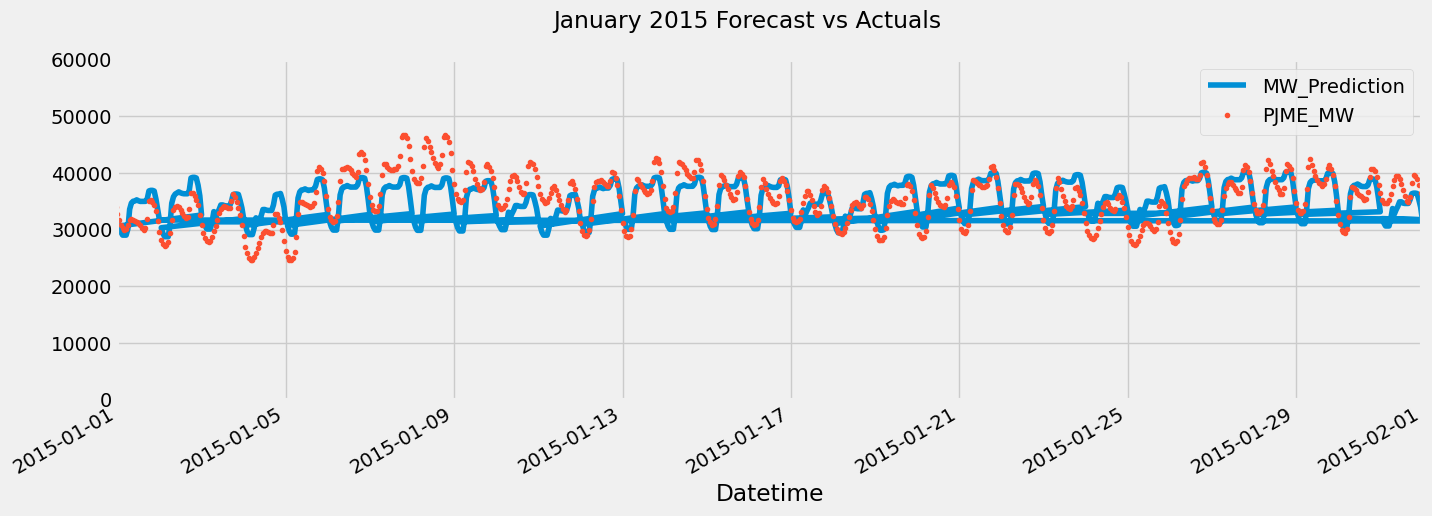

In [12]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

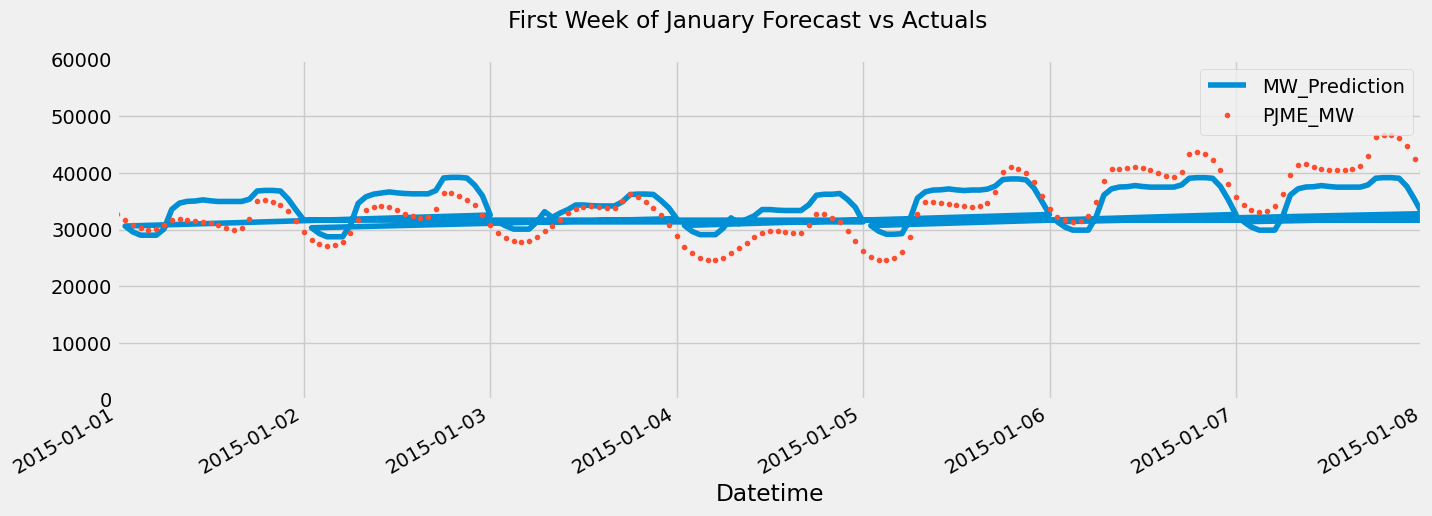

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

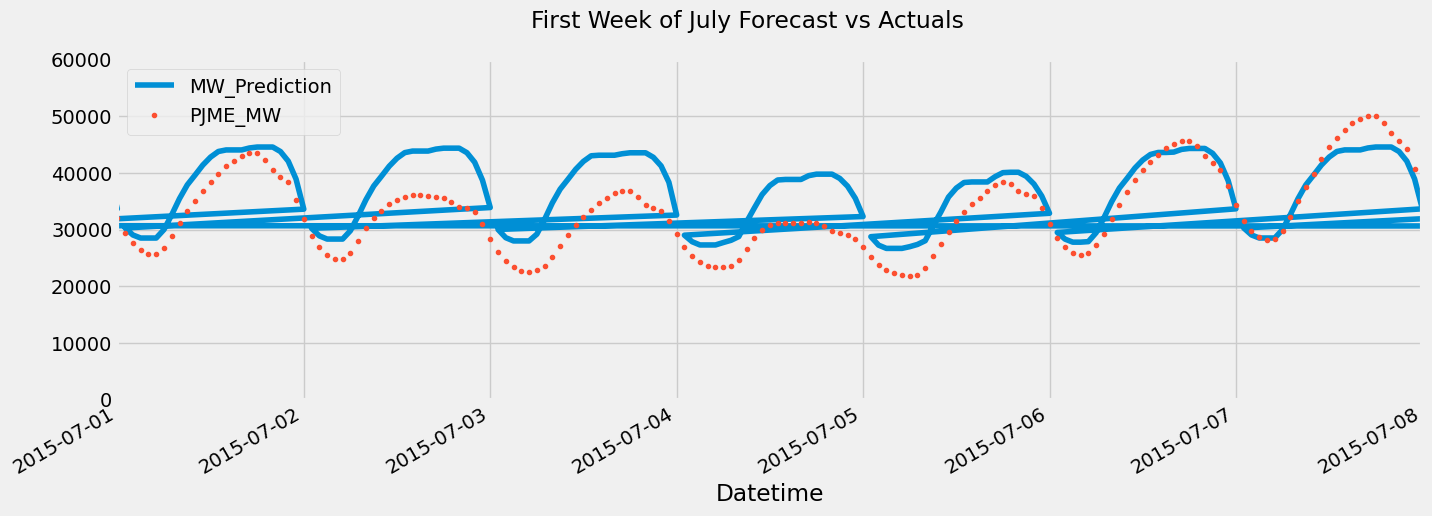

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')


In [15]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14000589.857027758

In [16]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2872.279854067599

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

np.float64(9.023368148598593)

In [19]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [20]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37712.667969 -9312.708903  9312.708903
2017 2     24          26445.083333   34055.777344 -7610.695312  7610.695312
     5     29          24528.416667   31988.181641 -7459.766439  7459.766439
2015 7     3           30024.875000   37480.753906 -7455.879313  7455.879313
2017 6     28          30531.208333   37768.800781 -7237.590495  7237.590495
           8           26943.791667   34138.117188 -7194.324382  7194.324382
     2     25          24344.458333   31415.802734 -7071.342855  7071.342855
2015 12    25          24466.083333   31505.533203 -7039.450521  7039.450521
2017 2     20          27070.583333   34098.894531 -7028.311930  7028.311930
2018 1     23          29773.833333   36784.167969 -7010.332357  7010.332357

In [21]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   32102.505859  13083.327311  13083.327311
           14          44427.333333   31411.716797  13015.617188  13015.617188
     9     10          40996.166667   29449.101562  11547.065918  11547.065918
           9           43836.958333   32349.212891  11487.743896  11487.743896
2015 2     20          44694.041667   33809.867188  10884.173747  10884.173747
2016 8     12          45724.708333   35156.425781  10568.281006  10568.281006
2018 1     6           43565.750000   33312.117188  10253.633301  10253.633301
2017 12    31          39016.000000   29078.435547   9937.566243   9937.566243
     5     19          38032.583333   28245.400391   9787.183024   9787.183024
2015 2     21          40918.666667   31169.890625   9748.777018   9748.777018

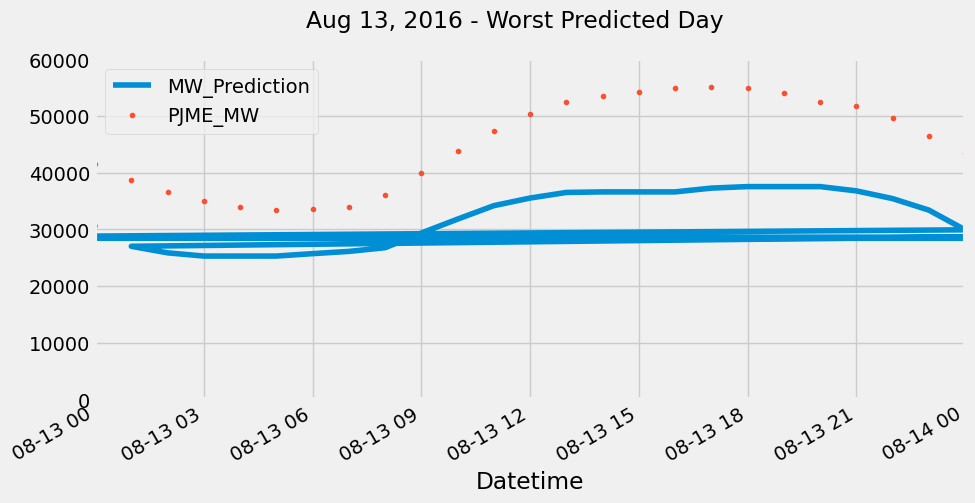

In [22]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

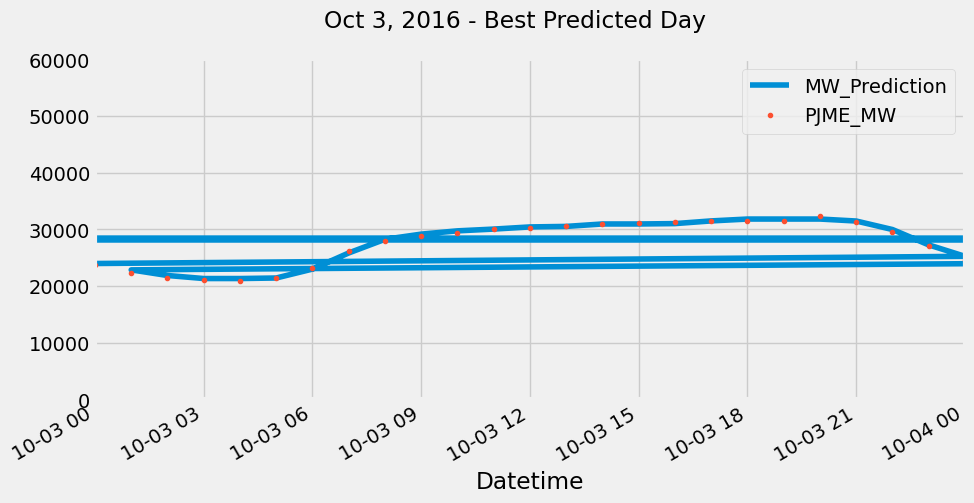

In [23]:


f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')



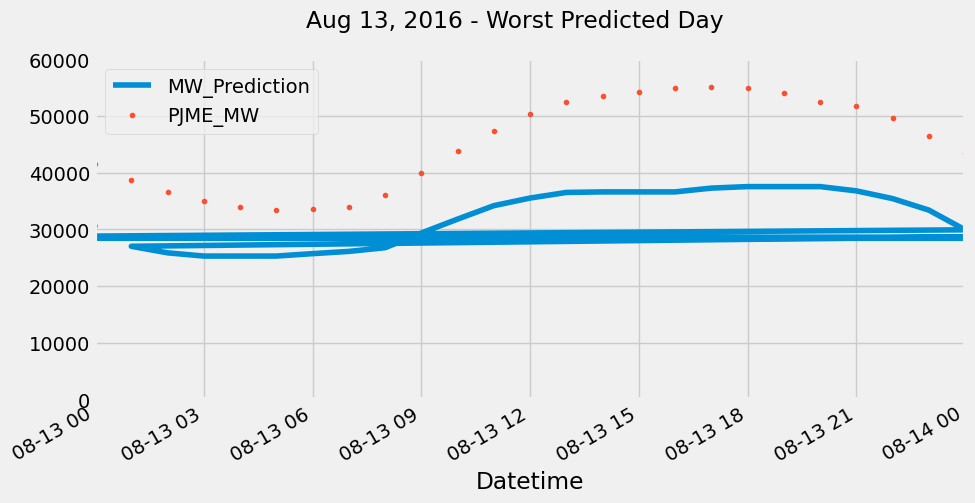

In [24]:


f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

